In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, dlossQ, _ = sess.run([model.d_lossA, model.d_lossQ, model.d_optA], #, model.d_optQ
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], #, model.d_optQ
                                feed_dict = {model.states: states, 
                                             model.actions: actions,
                                             model.targetQs: targetQs, 
                                             model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 gloss:1.3776 dlossA:1.3875 dlossQ:0.4687 exploreP:0.9986
Episode:1 meanR:25.5000 R:37.0000 rate:0.0740 gloss:1.3746 dlossA:1.3851 dlossQ:0.4683 exploreP:0.9950
Episode:2 meanR:21.0000 R:12.0000 rate:0.0240 gloss:1.3749 dlossA:1.3835 dlossQ:0.4730 exploreP:0.9938
Episode:3 meanR:19.7500 R:16.0000 rate:0.0320 gloss:1.3726 dlossA:1.3822 dlossQ:0.4752 exploreP:0.9922
Episode:4 meanR:20.6000 R:24.0000 rate:0.0480 gloss:1.3699 dlossA:1.3807 dlossQ:0.4712 exploreP:0.9899
Episode:5 meanR:19.1667 R:12.0000 rate:0.0240 gloss:1.3702 dlossA:1.3798 dlossQ:0.4738 exploreP:0.9887
Episode:6 meanR:22.1429 R:40.0000 rate:0.0800 gloss:1.3669 dlossA:1.3767 dlossQ:0.4758 exploreP:0.9848
Episode:7 meanR:21.2500 R:15.0000 rate:0.0300 gloss:1.3690 dlossA:1.3774 dlossQ:0.4734 exploreP:0.9833
Episode:8 meanR:20.7778 R:17.0000 rate:0.0340 gloss:1.3622 dlossA:1.3719 dlossQ:0.4796 exploreP:0.9817
Episode:9 meanR:21.5000 R:28.0000 rate:0.0560 gloss:1.3603 dlossA:1.3705 

Episode:79 meanR:20.9250 R:13.0000 rate:0.0260 gloss:1.3195 dlossA:1.3218 dlossQ:0.4655 exploreP:0.8474
Episode:80 meanR:20.8025 R:11.0000 rate:0.0220 gloss:1.3223 dlossA:1.3244 dlossQ:0.4656 exploreP:0.8465
Episode:81 meanR:20.7927 R:20.0000 rate:0.0400 gloss:1.3113 dlossA:1.3142 dlossQ:0.4688 exploreP:0.8448
Episode:82 meanR:20.7229 R:15.0000 rate:0.0300 gloss:1.3250 dlossA:1.3264 dlossQ:0.4579 exploreP:0.8436
Episode:83 meanR:20.8571 R:32.0000 rate:0.0640 gloss:1.3204 dlossA:1.3222 dlossQ:0.4672 exploreP:0.8409
Episode:84 meanR:20.8588 R:21.0000 rate:0.0420 gloss:1.3248 dlossA:1.3256 dlossQ:0.4538 exploreP:0.8392
Episode:85 meanR:20.7558 R:12.0000 rate:0.0240 gloss:1.3209 dlossA:1.3227 dlossQ:0.4609 exploreP:0.8382
Episode:86 meanR:20.6552 R:12.0000 rate:0.0240 gloss:1.3129 dlossA:1.3153 dlossQ:0.4772 exploreP:0.8372
Episode:87 meanR:20.5795 R:14.0000 rate:0.0280 gloss:1.3222 dlossA:1.3232 dlossQ:0.4652 exploreP:0.8360
Episode:88 meanR:20.7303 R:34.0000 rate:0.0680 gloss:1.3210 dlos

Episode:158 meanR:16.5200 R:19.0000 rate:0.0380 gloss:1.3176 dlossA:1.3178 dlossQ:0.5098 exploreP:0.7461
Episode:159 meanR:16.5000 R:22.0000 rate:0.0440 gloss:1.3144 dlossA:1.3148 dlossQ:0.5105 exploreP:0.7444
Episode:160 meanR:16.5000 R:12.0000 rate:0.0240 gloss:1.3155 dlossA:1.3159 dlossQ:0.5127 exploreP:0.7436
Episode:161 meanR:16.5300 R:20.0000 rate:0.0400 gloss:1.3207 dlossA:1.3210 dlossQ:0.5113 exploreP:0.7421
Episode:162 meanR:16.3900 R:10.0000 rate:0.0200 gloss:1.3136 dlossA:1.3139 dlossQ:0.5093 exploreP:0.7414
Episode:163 meanR:16.1700 R:12.0000 rate:0.0240 gloss:1.3154 dlossA:1.3158 dlossQ:0.5222 exploreP:0.7405
Episode:164 meanR:16.1500 R:12.0000 rate:0.0240 gloss:1.3130 dlossA:1.3134 dlossQ:0.5134 exploreP:0.7396
Episode:165 meanR:16.1300 R:14.0000 rate:0.0280 gloss:1.3164 dlossA:1.3168 dlossQ:0.5083 exploreP:0.7386
Episode:166 meanR:16.2500 R:28.0000 rate:0.0560 gloss:1.3208 dlossA:1.3210 dlossQ:0.5137 exploreP:0.7365
Episode:167 meanR:16.2000 R:10.0000 rate:0.0200 gloss:1

Episode:237 meanR:15.1000 R:13.0000 rate:0.0260 gloss:1.3173 dlossA:1.3175 dlossQ:0.5186 exploreP:0.6647
Episode:238 meanR:15.0900 R:13.0000 rate:0.0260 gloss:1.3124 dlossA:1.3125 dlossQ:0.5242 exploreP:0.6639
Episode:239 meanR:15.1200 R:12.0000 rate:0.0240 gloss:1.3269 dlossA:1.3269 dlossQ:0.5148 exploreP:0.6631
Episode:240 meanR:15.1900 R:18.0000 rate:0.0360 gloss:1.3116 dlossA:1.3116 dlossQ:0.5189 exploreP:0.6619
Episode:241 meanR:15.2100 R:13.0000 rate:0.0260 gloss:1.3265 dlossA:1.3267 dlossQ:0.5200 exploreP:0.6611
Episode:242 meanR:15.1300 R:10.0000 rate:0.0200 gloss:1.3185 dlossA:1.3185 dlossQ:0.5202 exploreP:0.6604
Episode:243 meanR:15.0400 R:18.0000 rate:0.0360 gloss:1.3174 dlossA:1.3175 dlossQ:0.5157 exploreP:0.6592
Episode:244 meanR:14.9800 R:8.0000 rate:0.0160 gloss:1.3212 dlossA:1.3214 dlossQ:0.5207 exploreP:0.6587
Episode:245 meanR:14.9700 R:11.0000 rate:0.0220 gloss:1.3280 dlossA:1.3280 dlossQ:0.5178 exploreP:0.6580
Episode:246 meanR:15.0100 R:17.0000 rate:0.0340 gloss:1.

Episode:316 meanR:14.7100 R:16.0000 rate:0.0320 gloss:1.3115 dlossA:1.3116 dlossQ:0.5185 exploreP:0.5918
Episode:317 meanR:14.7200 R:13.0000 rate:0.0260 gloss:1.3189 dlossA:1.3190 dlossQ:0.5145 exploreP:0.5910
Episode:318 meanR:14.6800 R:14.0000 rate:0.0280 gloss:1.3125 dlossA:1.3126 dlossQ:0.5150 exploreP:0.5902
Episode:319 meanR:14.6700 R:12.0000 rate:0.0240 gloss:1.3162 dlossA:1.3162 dlossQ:0.5160 exploreP:0.5895
Episode:320 meanR:14.7100 R:13.0000 rate:0.0260 gloss:1.3111 dlossA:1.3111 dlossQ:0.5672 exploreP:0.5888
Episode:321 meanR:14.6900 R:8.0000 rate:0.0160 gloss:1.3105 dlossA:1.3106 dlossQ:0.5131 exploreP:0.5883
Episode:322 meanR:14.6800 R:19.0000 rate:0.0380 gloss:1.3145 dlossA:1.3146 dlossQ:0.5124 exploreP:0.5872
Episode:323 meanR:14.7000 R:18.0000 rate:0.0360 gloss:1.3206 dlossA:1.3207 dlossQ:0.5170 exploreP:0.5862
Episode:324 meanR:14.7100 R:13.0000 rate:0.0260 gloss:1.3206 dlossA:1.3206 dlossQ:0.5213 exploreP:0.5854
Episode:325 meanR:14.7000 R:15.0000 rate:0.0300 gloss:1.

Episode:395 meanR:14.0800 R:16.0000 rate:0.0320 gloss:1.3174 dlossA:1.3175 dlossQ:0.5155 exploreP:0.5321
Episode:396 meanR:13.8900 R:12.0000 rate:0.0240 gloss:1.3127 dlossA:1.3128 dlossQ:0.5142 exploreP:0.5314
Episode:397 meanR:13.9800 R:21.0000 rate:0.0420 gloss:1.3171 dlossA:1.3171 dlossQ:0.5103 exploreP:0.5304
Episode:398 meanR:14.0100 R:16.0000 rate:0.0320 gloss:1.3173 dlossA:1.3177 dlossQ:0.5194 exploreP:0.5295
Episode:399 meanR:13.9900 R:11.0000 rate:0.0220 gloss:1.3103 dlossA:1.3104 dlossQ:0.5161 exploreP:0.5289
Episode:400 meanR:13.9700 R:11.0000 rate:0.0220 gloss:1.3153 dlossA:1.3154 dlossQ:0.5192 exploreP:0.5284
Episode:401 meanR:13.9700 R:12.0000 rate:0.0240 gloss:1.3164 dlossA:1.3165 dlossQ:0.5145 exploreP:0.5278
Episode:402 meanR:13.9100 R:11.0000 rate:0.0220 gloss:1.3087 dlossA:1.3088 dlossQ:0.5122 exploreP:0.5272
Episode:403 meanR:13.8700 R:13.0000 rate:0.0260 gloss:1.3159 dlossA:1.3159 dlossQ:0.5157 exploreP:0.5265
Episode:404 meanR:13.9100 R:12.0000 rate:0.0240 gloss:1

Episode:474 meanR:12.9900 R:16.0000 rate:0.0320 gloss:1.3176 dlossA:1.3177 dlossQ:0.5129 exploreP:0.4814
Episode:475 meanR:12.9400 R:10.0000 rate:0.0200 gloss:1.3120 dlossA:1.3120 dlossQ:0.5136 exploreP:0.4809
Episode:476 meanR:12.9300 R:12.0000 rate:0.0240 gloss:1.3149 dlossA:1.3150 dlossQ:0.5122 exploreP:0.4803
Episode:477 meanR:12.8700 R:10.0000 rate:0.0200 gloss:1.3206 dlossA:1.3206 dlossQ:0.5103 exploreP:0.4798
Episode:478 meanR:12.9000 R:15.0000 rate:0.0300 gloss:1.3170 dlossA:1.3173 dlossQ:0.5201 exploreP:0.4791
Episode:479 meanR:12.8700 R:11.0000 rate:0.0220 gloss:1.3215 dlossA:1.3215 dlossQ:0.5182 exploreP:0.4786
Episode:480 meanR:12.8900 R:12.0000 rate:0.0240 gloss:1.3060 dlossA:1.3064 dlossQ:0.5129 exploreP:0.4781
Episode:481 meanR:12.7500 R:9.0000 rate:0.0180 gloss:1.3108 dlossA:1.3110 dlossQ:0.5114 exploreP:0.4776
Episode:482 meanR:12.7800 R:12.0000 rate:0.0240 gloss:1.3136 dlossA:1.3140 dlossQ:0.5177 exploreP:0.4771
Episode:483 meanR:12.7800 R:16.0000 rate:0.0320 gloss:1.

Episode:553 meanR:12.8300 R:10.0000 rate:0.0200 gloss:1.3207 dlossA:1.3210 dlossQ:0.5182 exploreP:0.4352
Episode:554 meanR:12.8300 R:12.0000 rate:0.0240 gloss:1.3150 dlossA:1.3155 dlossQ:0.5205 exploreP:0.4347
Episode:555 meanR:12.8700 R:17.0000 rate:0.0340 gloss:1.3194 dlossA:1.3195 dlossQ:0.5135 exploreP:0.4340
Episode:556 meanR:12.8800 R:11.0000 rate:0.0220 gloss:1.3156 dlossA:1.3158 dlossQ:0.5193 exploreP:0.4335
Episode:557 meanR:12.8600 R:8.0000 rate:0.0160 gloss:1.3080 dlossA:1.3081 dlossQ:0.5169 exploreP:0.4332
Episode:558 meanR:12.8900 R:13.0000 rate:0.0260 gloss:1.3287 dlossA:1.3293 dlossQ:0.5211 exploreP:0.4326
Episode:559 meanR:12.8200 R:9.0000 rate:0.0180 gloss:1.3141 dlossA:1.3141 dlossQ:0.5176 exploreP:0.4323
Episode:560 meanR:12.7900 R:12.0000 rate:0.0240 gloss:1.3189 dlossA:1.3190 dlossQ:0.5197 exploreP:0.4317
Episode:561 meanR:12.7600 R:13.0000 rate:0.0260 gloss:1.3063 dlossA:1.3065 dlossQ:0.5218 exploreP:0.4312
Episode:562 meanR:12.7500 R:10.0000 rate:0.0200 gloss:1.3

Episode:632 meanR:12.5900 R:11.0000 rate:0.0220 gloss:1.3140 dlossA:1.3142 dlossQ:0.5220 exploreP:0.3956
Episode:633 meanR:12.6100 R:11.0000 rate:0.0220 gloss:1.3220 dlossA:1.3222 dlossQ:0.5216 exploreP:0.3952
Episode:634 meanR:12.6400 R:12.0000 rate:0.0240 gloss:1.3116 dlossA:1.3124 dlossQ:0.5219 exploreP:0.3947
Episode:635 meanR:12.4600 R:9.0000 rate:0.0180 gloss:1.3209 dlossA:1.3209 dlossQ:0.5164 exploreP:0.3944
Episode:636 meanR:12.4700 R:14.0000 rate:0.0280 gloss:1.3210 dlossA:1.3212 dlossQ:0.5167 exploreP:0.3938
Episode:637 meanR:12.3800 R:9.0000 rate:0.0180 gloss:1.3144 dlossA:1.3148 dlossQ:0.5246 exploreP:0.3935
Episode:638 meanR:12.3900 R:10.0000 rate:0.0200 gloss:1.3138 dlossA:1.3139 dlossQ:0.5171 exploreP:0.3931
Episode:639 meanR:12.3600 R:11.0000 rate:0.0220 gloss:1.3201 dlossA:1.3201 dlossQ:0.5210 exploreP:0.3927
Episode:640 meanR:12.3500 R:10.0000 rate:0.0200 gloss:1.3115 dlossA:1.3116 dlossQ:0.5297 exploreP:0.3923
Episode:641 meanR:12.4300 R:19.0000 rate:0.0380 gloss:1.3

Episode:711 meanR:11.9100 R:11.0000 rate:0.0220 gloss:1.3206 dlossA:1.3216 dlossQ:0.5334 exploreP:0.3618
Episode:712 meanR:11.8300 R:9.0000 rate:0.0180 gloss:1.3209 dlossA:1.3210 dlossQ:0.5216 exploreP:0.3615
Episode:713 meanR:11.8300 R:12.0000 rate:0.0240 gloss:1.3140 dlossA:1.3140 dlossQ:0.5171 exploreP:0.3610
Episode:714 meanR:11.7600 R:11.0000 rate:0.0220 gloss:1.3172 dlossA:1.3175 dlossQ:0.5171 exploreP:0.3607
Episode:715 meanR:11.8000 R:13.0000 rate:0.0260 gloss:1.3128 dlossA:1.3129 dlossQ:0.5152 exploreP:0.3602
Episode:716 meanR:11.7700 R:12.0000 rate:0.0240 gloss:1.3229 dlossA:1.3230 dlossQ:0.5209 exploreP:0.3598
Episode:717 meanR:11.8000 R:14.0000 rate:0.0280 gloss:1.3179 dlossA:1.3180 dlossQ:0.5148 exploreP:0.3593
Episode:718 meanR:11.7500 R:13.0000 rate:0.0260 gloss:1.3140 dlossA:1.3148 dlossQ:0.5259 exploreP:0.3588
Episode:719 meanR:11.7000 R:10.0000 rate:0.0200 gloss:1.3161 dlossA:1.3163 dlossQ:0.5113 exploreP:0.3585
Episode:720 meanR:11.6800 R:10.0000 rate:0.0200 gloss:1.

Episode:790 meanR:11.7100 R:10.0000 rate:0.0200 gloss:1.3239 dlossA:1.3240 dlossQ:0.5180 exploreP:0.3310
Episode:791 meanR:11.7100 R:12.0000 rate:0.0240 gloss:1.3094 dlossA:1.3099 dlossQ:0.5227 exploreP:0.3306
Episode:792 meanR:11.7600 R:14.0000 rate:0.0280 gloss:1.3034 dlossA:1.3036 dlossQ:0.5177 exploreP:0.3302
Episode:793 meanR:11.6600 R:11.0000 rate:0.0220 gloss:1.3101 dlossA:1.3103 dlossQ:0.5188 exploreP:0.3298
Episode:794 meanR:11.6500 R:10.0000 rate:0.0200 gloss:1.3208 dlossA:1.3210 dlossQ:0.5151 exploreP:0.3295
Episode:795 meanR:11.5300 R:14.0000 rate:0.0280 gloss:1.3091 dlossA:1.3093 dlossQ:0.5158 exploreP:0.3291
Episode:796 meanR:11.5200 R:9.0000 rate:0.0180 gloss:1.3075 dlossA:1.3076 dlossQ:0.5097 exploreP:0.3288
Episode:797 meanR:11.5000 R:10.0000 rate:0.0200 gloss:1.3038 dlossA:1.3041 dlossQ:0.5166 exploreP:0.3285
Episode:798 meanR:11.5200 R:12.0000 rate:0.0240 gloss:1.3107 dlossA:1.3107 dlossQ:0.5107 exploreP:0.3281
Episode:799 meanR:11.5600 R:14.0000 rate:0.0280 gloss:1.

Episode:869 meanR:11.2900 R:14.0000 rate:0.0280 gloss:1.3164 dlossA:1.3167 dlossQ:0.5214 exploreP:0.3036
Episode:870 meanR:11.2700 R:9.0000 rate:0.0180 gloss:1.3108 dlossA:1.3109 dlossQ:0.5182 exploreP:0.3034
Episode:871 meanR:11.2700 R:11.0000 rate:0.0220 gloss:1.3138 dlossA:1.3139 dlossQ:0.5195 exploreP:0.3030
Episode:872 meanR:11.2800 R:15.0000 rate:0.0300 gloss:1.3197 dlossA:1.3198 dlossQ:0.5190 exploreP:0.3026
Episode:873 meanR:11.2700 R:9.0000 rate:0.0180 gloss:1.3128 dlossA:1.3128 dlossQ:0.5229 exploreP:0.3023
Episode:874 meanR:11.2600 R:10.0000 rate:0.0200 gloss:1.3170 dlossA:1.3172 dlossQ:0.5193 exploreP:0.3020
Episode:875 meanR:11.2400 R:10.0000 rate:0.0200 gloss:1.3146 dlossA:1.3147 dlossQ:0.5148 exploreP:0.3018
Episode:876 meanR:11.2300 R:10.0000 rate:0.0200 gloss:1.3110 dlossA:1.3112 dlossQ:0.5171 exploreP:0.3015
Episode:877 meanR:11.2000 R:10.0000 rate:0.0200 gloss:1.3085 dlossA:1.3086 dlossQ:0.5113 exploreP:0.3012
Episode:878 meanR:11.2200 R:11.0000 rate:0.0220 gloss:1.3

Episode:948 meanR:11.0400 R:10.0000 rate:0.0200 gloss:1.3088 dlossA:1.3090 dlossQ:0.5192 exploreP:0.2793
Episode:949 meanR:11.0500 R:11.0000 rate:0.0220 gloss:1.3178 dlossA:1.3187 dlossQ:0.5257 exploreP:0.2790
Episode:950 meanR:11.0500 R:11.0000 rate:0.0220 gloss:1.3240 dlossA:1.3240 dlossQ:0.5175 exploreP:0.2787
Episode:951 meanR:11.0200 R:9.0000 rate:0.0180 gloss:1.3108 dlossA:1.3111 dlossQ:0.5210 exploreP:0.2784
Episode:952 meanR:11.0300 R:9.0000 rate:0.0180 gloss:1.3106 dlossA:1.3108 dlossQ:0.5182 exploreP:0.2782
Episode:953 meanR:11.0300 R:14.0000 rate:0.0280 gloss:1.3169 dlossA:1.3172 dlossQ:0.5269 exploreP:0.2778
Episode:954 meanR:11.0500 R:10.0000 rate:0.0200 gloss:1.3160 dlossA:1.3171 dlossQ:0.5284 exploreP:0.2775
Episode:955 meanR:11.0100 R:10.0000 rate:0.0200 gloss:1.3047 dlossA:1.3049 dlossQ:0.5181 exploreP:0.2773
Episode:956 meanR:11.0300 R:10.0000 rate:0.0200 gloss:1.3092 dlossA:1.3094 dlossQ:0.5183 exploreP:0.2770
Episode:957 meanR:11.0300 R:10.0000 rate:0.0200 gloss:1.2

Episode:1026 meanR:10.8600 R:8.0000 rate:0.0160 gloss:1.3230 dlossA:1.3229 dlossQ:0.5200 exploreP:0.2575
Episode:1027 meanR:10.8500 R:11.0000 rate:0.0220 gloss:1.3079 dlossA:1.3081 dlossQ:0.5212 exploreP:0.2572
Episode:1028 meanR:10.7900 R:8.0000 rate:0.0160 gloss:1.3320 dlossA:1.3323 dlossQ:0.5212 exploreP:0.2570
Episode:1029 meanR:10.8200 R:14.0000 rate:0.0280 gloss:1.3147 dlossA:1.3148 dlossQ:0.5164 exploreP:0.2567
Episode:1030 meanR:10.8300 R:12.0000 rate:0.0240 gloss:1.3170 dlossA:1.3177 dlossQ:0.5770 exploreP:0.2564
Episode:1031 meanR:10.8300 R:11.0000 rate:0.0220 gloss:1.3141 dlossA:1.3142 dlossQ:0.5251 exploreP:0.2561
Episode:1032 meanR:10.8400 R:11.0000 rate:0.0220 gloss:1.3062 dlossA:1.3064 dlossQ:0.5185 exploreP:0.2558
Episode:1033 meanR:10.8400 R:8.0000 rate:0.0160 gloss:1.3202 dlossA:1.3205 dlossQ:0.5292 exploreP:0.2556
Episode:1034 meanR:10.8400 R:11.0000 rate:0.0220 gloss:1.3132 dlossA:1.3134 dlossQ:0.5213 exploreP:0.2554
Episode:1035 meanR:10.8400 R:12.0000 rate:0.0240 

Episode:1104 meanR:10.6000 R:13.0000 rate:0.0260 gloss:1.3023 dlossA:1.3028 dlossQ:0.5201 exploreP:0.2378
Episode:1105 meanR:10.5800 R:10.0000 rate:0.0200 gloss:1.3023 dlossA:1.3025 dlossQ:0.5160 exploreP:0.2376
Episode:1106 meanR:10.5900 R:10.0000 rate:0.0200 gloss:1.3074 dlossA:1.3075 dlossQ:0.5104 exploreP:0.2374
Episode:1107 meanR:10.5800 R:10.0000 rate:0.0200 gloss:1.3025 dlossA:1.3028 dlossQ:0.5125 exploreP:0.2371
Episode:1108 meanR:10.5600 R:10.0000 rate:0.0200 gloss:1.3115 dlossA:1.3116 dlossQ:0.5117 exploreP:0.2369
Episode:1109 meanR:10.5500 R:10.0000 rate:0.0200 gloss:1.3146 dlossA:1.3147 dlossQ:0.5207 exploreP:0.2367
Episode:1110 meanR:10.5500 R:10.0000 rate:0.0200 gloss:1.3192 dlossA:1.3205 dlossQ:0.5351 exploreP:0.2364
Episode:1111 meanR:10.5400 R:9.0000 rate:0.0180 gloss:1.3241 dlossA:1.3241 dlossQ:0.5131 exploreP:0.2362
Episode:1112 meanR:10.5300 R:10.0000 rate:0.0200 gloss:1.3239 dlossA:1.3240 dlossQ:0.5992 exploreP:0.2360
Episode:1113 meanR:10.5700 R:14.0000 rate:0.028

Episode:1182 meanR:10.4300 R:10.0000 rate:0.0200 gloss:1.3057 dlossA:1.3058 dlossQ:0.5125 exploreP:0.2201
Episode:1183 meanR:10.4500 R:11.0000 rate:0.0220 gloss:1.3039 dlossA:1.3042 dlossQ:0.5136 exploreP:0.2199
Episode:1184 meanR:10.4400 R:9.0000 rate:0.0180 gloss:1.3261 dlossA:1.3272 dlossQ:0.5329 exploreP:0.2197
Episode:1185 meanR:10.4400 R:10.0000 rate:0.0200 gloss:1.3253 dlossA:1.3254 dlossQ:0.5333 exploreP:0.2195
Episode:1186 meanR:10.4600 R:15.0000 rate:0.0300 gloss:1.3051 dlossA:1.3054 dlossQ:0.5242 exploreP:0.2192
Episode:1187 meanR:10.4300 R:9.0000 rate:0.0180 gloss:1.3173 dlossA:1.3179 dlossQ:0.5377 exploreP:0.2190
Episode:1188 meanR:10.4200 R:8.0000 rate:0.0160 gloss:1.3113 dlossA:1.3125 dlossQ:0.5510 exploreP:0.2188
Episode:1189 meanR:10.3900 R:9.0000 rate:0.0180 gloss:1.3096 dlossA:1.3098 dlossQ:0.5162 exploreP:0.2187
Episode:1190 meanR:10.4000 R:10.0000 rate:0.0200 gloss:1.3062 dlossA:1.3065 dlossQ:0.5213 exploreP:0.2185
Episode:1191 meanR:10.3900 R:9.0000 rate:0.0180 gl

Episode:1260 meanR:10.3400 R:12.0000 rate:0.0240 gloss:1.3103 dlossA:1.3106 dlossQ:0.5281 exploreP:0.2037
Episode:1261 meanR:10.3400 R:9.0000 rate:0.0180 gloss:1.3065 dlossA:1.3068 dlossQ:0.5249 exploreP:0.2035
Episode:1262 meanR:10.4100 R:17.0000 rate:0.0340 gloss:1.3149 dlossA:1.3150 dlossQ:0.5201 exploreP:0.2032
Episode:1263 meanR:10.3700 R:9.0000 rate:0.0180 gloss:1.3074 dlossA:1.3091 dlossQ:0.5390 exploreP:0.2030
Episode:1264 meanR:10.3600 R:9.0000 rate:0.0180 gloss:1.3066 dlossA:1.3072 dlossQ:0.5248 exploreP:0.2028
Episode:1265 meanR:10.3700 R:9.0000 rate:0.0180 gloss:1.3038 dlossA:1.3041 dlossQ:0.5233 exploreP:0.2027
Episode:1266 meanR:10.4200 R:14.0000 rate:0.0280 gloss:1.3032 dlossA:1.3035 dlossQ:0.5225 exploreP:0.2024
Episode:1267 meanR:10.4000 R:9.0000 rate:0.0180 gloss:1.3139 dlossA:1.3142 dlossQ:0.5234 exploreP:0.2022
Episode:1268 meanR:10.3600 R:10.0000 rate:0.0200 gloss:1.3119 dlossA:1.3120 dlossQ:0.5214 exploreP:0.2020
Episode:1269 meanR:10.4100 R:13.0000 rate:0.0260 gl

Episode:1338 meanR:10.7300 R:11.0000 rate:0.0220 gloss:1.3070 dlossA:1.3075 dlossQ:0.5220 exploreP:0.1881
Episode:1339 meanR:10.7800 R:13.0000 rate:0.0260 gloss:1.2911 dlossA:1.2916 dlossQ:0.5069 exploreP:0.1879
Episode:1340 meanR:10.7900 R:11.0000 rate:0.0220 gloss:1.3077 dlossA:1.3079 dlossQ:0.5154 exploreP:0.1877
Episode:1341 meanR:10.7900 R:10.0000 rate:0.0200 gloss:1.3050 dlossA:1.3055 dlossQ:0.5193 exploreP:0.1875
Episode:1342 meanR:10.7700 R:9.0000 rate:0.0180 gloss:1.3151 dlossA:1.3155 dlossQ:0.5172 exploreP:0.1873
Episode:1343 meanR:10.7400 R:8.0000 rate:0.0160 gloss:1.3079 dlossA:1.3080 dlossQ:0.5106 exploreP:0.1872
Episode:1344 meanR:10.7500 R:11.0000 rate:0.0220 gloss:1.3031 dlossA:1.3046 dlossQ:0.5237 exploreP:0.1870
Episode:1345 meanR:10.7600 R:12.0000 rate:0.0240 gloss:1.3124 dlossA:1.3128 dlossQ:0.5211 exploreP:0.1868
Episode:1346 meanR:10.7700 R:11.0000 rate:0.0220 gloss:1.2997 dlossA:1.3015 dlossQ:0.5437 exploreP:0.1866
Episode:1347 meanR:10.8100 R:15.0000 rate:0.0300

Episode:1416 meanR:10.5400 R:9.0000 rate:0.0180 gloss:1.3104 dlossA:1.3105 dlossQ:0.5153 exploreP:0.1741
Episode:1417 meanR:10.5500 R:12.0000 rate:0.0240 gloss:1.3139 dlossA:1.3142 dlossQ:0.5174 exploreP:0.1739
Episode:1418 meanR:10.5400 R:10.0000 rate:0.0200 gloss:1.3127 dlossA:1.3129 dlossQ:0.5153 exploreP:0.1737
Episode:1419 meanR:10.5200 R:9.0000 rate:0.0180 gloss:1.3009 dlossA:1.3012 dlossQ:0.5184 exploreP:0.1736
Episode:1420 meanR:10.5300 R:11.0000 rate:0.0220 gloss:1.3068 dlossA:1.3071 dlossQ:0.5108 exploreP:0.1734
Episode:1421 meanR:10.5000 R:8.0000 rate:0.0160 gloss:1.3061 dlossA:1.3066 dlossQ:0.5191 exploreP:0.1733
Episode:1422 meanR:10.5300 R:12.0000 rate:0.0240 gloss:1.2925 dlossA:1.2932 dlossQ:0.5183 exploreP:0.1731
Episode:1423 meanR:10.4300 R:9.0000 rate:0.0180 gloss:1.3068 dlossA:1.3069 dlossQ:0.5092 exploreP:0.1729
Episode:1424 meanR:10.4500 R:10.0000 rate:0.0200 gloss:1.3020 dlossA:1.3024 dlossQ:0.5116 exploreP:0.1728
Episode:1425 meanR:10.4900 R:14.0000 rate:0.0280 g

Episode:1494 meanR:10.2900 R:12.0000 rate:0.0240 gloss:1.3174 dlossA:1.3177 dlossQ:0.5166 exploreP:0.1615
Episode:1495 meanR:10.2700 R:9.0000 rate:0.0180 gloss:1.3165 dlossA:1.3169 dlossQ:0.5222 exploreP:0.1613
Episode:1496 meanR:10.2600 R:10.0000 rate:0.0200 gloss:1.3069 dlossA:1.3072 dlossQ:0.5298 exploreP:0.1612
Episode:1497 meanR:10.2600 R:12.0000 rate:0.0240 gloss:1.3058 dlossA:1.3059 dlossQ:0.5237 exploreP:0.1610
Episode:1498 meanR:10.2500 R:9.0000 rate:0.0180 gloss:1.3017 dlossA:1.3019 dlossQ:0.5255 exploreP:0.1609
Episode:1499 meanR:10.2700 R:10.0000 rate:0.0200 gloss:1.3020 dlossA:1.3024 dlossQ:0.5214 exploreP:0.1607
Episode:1500 meanR:10.2700 R:9.0000 rate:0.0180 gloss:1.3159 dlossA:1.3161 dlossQ:0.5234 exploreP:0.1606
Episode:1501 meanR:10.2700 R:10.0000 rate:0.0200 gloss:1.3087 dlossA:1.3090 dlossQ:0.5234 exploreP:0.1604
Episode:1502 meanR:10.2800 R:10.0000 rate:0.0200 gloss:1.3153 dlossA:1.3154 dlossQ:0.5318 exploreP:0.1603
Episode:1503 meanR:10.2700 R:10.0000 rate:0.0200 

Episode:1572 meanR:10.3500 R:10.0000 rate:0.0200 gloss:1.3102 dlossA:1.3103 dlossQ:0.5267 exploreP:0.1497
Episode:1573 meanR:10.3900 R:14.0000 rate:0.0280 gloss:1.3171 dlossA:1.3173 dlossQ:0.5256 exploreP:0.1495
Episode:1574 meanR:10.4000 R:10.0000 rate:0.0200 gloss:1.3092 dlossA:1.3094 dlossQ:0.5263 exploreP:0.1494
Episode:1575 meanR:10.4400 R:14.0000 rate:0.0280 gloss:1.2982 dlossA:1.2984 dlossQ:0.5266 exploreP:0.1492
Episode:1576 meanR:10.4000 R:8.0000 rate:0.0160 gloss:1.3136 dlossA:1.3142 dlossQ:0.5424 exploreP:0.1491
Episode:1577 meanR:10.4300 R:15.0000 rate:0.0300 gloss:1.3134 dlossA:1.3136 dlossQ:0.5280 exploreP:0.1489
Episode:1578 meanR:10.3800 R:8.0000 rate:0.0160 gloss:1.2995 dlossA:1.2997 dlossQ:0.5175 exploreP:0.1488
Episode:1579 meanR:10.4200 R:13.0000 rate:0.0260 gloss:1.3119 dlossA:1.3121 dlossQ:0.5198 exploreP:0.1486
Episode:1580 meanR:10.4200 R:10.0000 rate:0.0200 gloss:1.3200 dlossA:1.3203 dlossQ:0.5321 exploreP:0.1484
Episode:1581 meanR:10.4000 R:9.0000 rate:0.0180 

Episode:1650 meanR:10.1500 R:10.0000 rate:0.0200 gloss:1.2915 dlossA:1.2920 dlossQ:0.5192 exploreP:0.1391
Episode:1651 meanR:10.1600 R:10.0000 rate:0.0200 gloss:1.3176 dlossA:1.3180 dlossQ:0.5180 exploreP:0.1389
Episode:1652 meanR:10.1500 R:10.0000 rate:0.0200 gloss:1.3003 dlossA:1.3022 dlossQ:0.5328 exploreP:0.1388
Episode:1653 meanR:10.1600 R:9.0000 rate:0.0180 gloss:1.3004 dlossA:1.3011 dlossQ:0.5308 exploreP:0.1387
Episode:1654 meanR:10.1000 R:9.0000 rate:0.0180 gloss:1.3000 dlossA:1.3003 dlossQ:0.5224 exploreP:0.1386
Episode:1655 meanR:10.0800 R:10.0000 rate:0.0200 gloss:1.2978 dlossA:1.2981 dlossQ:0.5227 exploreP:0.1385
Episode:1656 meanR:10.0800 R:10.0000 rate:0.0200 gloss:1.3152 dlossA:1.3184 dlossQ:0.5578 exploreP:0.1383
Episode:1657 meanR:10.0800 R:10.0000 rate:0.0200 gloss:1.3112 dlossA:1.3116 dlossQ:0.5215 exploreP:0.1382
Episode:1658 meanR:10.0800 R:11.0000 rate:0.0220 gloss:1.3018 dlossA:1.3022 dlossQ:0.5222 exploreP:0.1381
Episode:1659 meanR:10.0900 R:10.0000 rate:0.0200

Episode:1728 meanR:10.0500 R:9.0000 rate:0.0180 gloss:1.3091 dlossA:1.3095 dlossQ:0.5213 exploreP:0.1294
Episode:1729 meanR:10.0500 R:10.0000 rate:0.0200 gloss:1.2966 dlossA:1.2970 dlossQ:0.5214 exploreP:0.1293
Episode:1730 meanR:10.0400 R:10.0000 rate:0.0200 gloss:1.3007 dlossA:1.3013 dlossQ:0.5350 exploreP:0.1292
Episode:1731 meanR:10.0400 R:10.0000 rate:0.0200 gloss:1.3207 dlossA:1.3210 dlossQ:0.5240 exploreP:0.1290
Episode:1732 meanR:10.0200 R:8.0000 rate:0.0160 gloss:1.2844 dlossA:1.2848 dlossQ:0.5274 exploreP:0.1289
Episode:1733 meanR:10.0200 R:11.0000 rate:0.0220 gloss:1.2930 dlossA:1.2935 dlossQ:0.5232 exploreP:0.1288
Episode:1734 meanR:9.9900 R:10.0000 rate:0.0200 gloss:1.3064 dlossA:1.3070 dlossQ:0.5223 exploreP:0.1287
Episode:1735 meanR:9.9900 R:10.0000 rate:0.0200 gloss:1.3018 dlossA:1.3022 dlossQ:0.5133 exploreP:0.1286
Episode:1736 meanR:9.9900 R:9.0000 rate:0.0180 gloss:1.3093 dlossA:1.3096 dlossQ:0.5136 exploreP:0.1285
Episode:1737 meanR:9.9600 R:8.0000 rate:0.0160 gloss

Episode:1807 meanR:9.8900 R:10.0000 rate:0.0200 gloss:1.2830 dlossA:1.2839 dlossQ:0.5339 exploreP:0.1205
Episode:1808 meanR:9.8500 R:8.0000 rate:0.0160 gloss:1.3111 dlossA:1.3116 dlossQ:0.5264 exploreP:0.1204
Episode:1809 meanR:9.8100 R:8.0000 rate:0.0160 gloss:1.3138 dlossA:1.3138 dlossQ:0.5144 exploreP:0.1203
Episode:1810 meanR:9.8000 R:10.0000 rate:0.0200 gloss:1.3075 dlossA:1.3077 dlossQ:0.5225 exploreP:0.1202
Episode:1811 meanR:9.8000 R:9.0000 rate:0.0180 gloss:1.2942 dlossA:1.2947 dlossQ:0.5144 exploreP:0.1201
Episode:1812 meanR:9.8000 R:9.0000 rate:0.0180 gloss:1.3021 dlossA:1.3024 dlossQ:0.5262 exploreP:0.1200
Episode:1813 meanR:9.7900 R:11.0000 rate:0.0220 gloss:1.2960 dlossA:1.2965 dlossQ:0.5177 exploreP:0.1199
Episode:1814 meanR:9.7900 R:9.0000 rate:0.0180 gloss:1.2804 dlossA:1.2812 dlossQ:0.5114 exploreP:0.1198
Episode:1815 meanR:9.8300 R:14.0000 rate:0.0280 gloss:1.3030 dlossA:1.3034 dlossQ:0.5166 exploreP:0.1196
Episode:1816 meanR:9.8200 R:10.0000 rate:0.0200 gloss:1.2965

Episode:1886 meanR:10.1000 R:10.0000 rate:0.0200 gloss:1.3108 dlossA:1.3116 dlossQ:0.5382 exploreP:0.1119
Episode:1887 meanR:10.1000 R:11.0000 rate:0.0220 gloss:1.3167 dlossA:1.3171 dlossQ:0.5314 exploreP:0.1118
Episode:1888 meanR:10.1200 R:10.0000 rate:0.0200 gloss:1.2984 dlossA:1.3002 dlossQ:0.5422 exploreP:0.1117
Episode:1889 meanR:10.1300 R:10.0000 rate:0.0200 gloss:1.3047 dlossA:1.3072 dlossQ:0.5622 exploreP:0.1116
Episode:1890 meanR:10.1100 R:8.0000 rate:0.0160 gloss:1.2982 dlossA:1.3023 dlossQ:0.5680 exploreP:0.1115
Episode:1891 meanR:10.1200 R:10.0000 rate:0.0200 gloss:1.2973 dlossA:1.2989 dlossQ:0.5304 exploreP:0.1114
Episode:1892 meanR:10.1100 R:10.0000 rate:0.0200 gloss:1.3075 dlossA:1.3111 dlossQ:0.5728 exploreP:0.1113
Episode:1893 meanR:10.1000 R:9.0000 rate:0.0180 gloss:1.3051 dlossA:1.3092 dlossQ:0.5657 exploreP:0.1113
Episode:1894 meanR:10.0800 R:9.0000 rate:0.0180 gloss:1.3304 dlossA:1.3309 dlossQ:0.5519 exploreP:0.1112
Episode:1895 meanR:10.0900 R:10.0000 rate:0.0200 

Episode:1964 meanR:9.9300 R:9.0000 rate:0.0180 gloss:1.3055 dlossA:1.3056 dlossQ:0.5108 exploreP:0.1044
Episode:1965 meanR:9.9500 R:11.0000 rate:0.0220 gloss:1.3059 dlossA:1.3067 dlossQ:0.5377 exploreP:0.1043
Episode:1966 meanR:9.9900 R:14.0000 rate:0.0280 gloss:1.3083 dlossA:1.3087 dlossQ:0.5189 exploreP:0.1041
Episode:1967 meanR:9.9800 R:10.0000 rate:0.0200 gloss:1.3010 dlossA:1.3015 dlossQ:0.5220 exploreP:0.1040
Episode:1968 meanR:10.0000 R:11.0000 rate:0.0220 gloss:1.2951 dlossA:1.2953 dlossQ:0.5253 exploreP:0.1039
Episode:1969 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.3073 dlossA:1.3081 dlossQ:0.5326 exploreP:0.1038
Episode:1970 meanR:10.0000 R:12.0000 rate:0.0240 gloss:1.3100 dlossA:1.3106 dlossQ:0.5327 exploreP:0.1037
Episode:1971 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.3174 dlossA:1.3203 dlossQ:0.5560 exploreP:0.1036
Episode:1972 meanR:9.9900 R:10.0000 rate:0.0200 gloss:1.2932 dlossA:1.2937 dlossQ:0.5392 exploreP:0.1035
Episode:1973 meanR:9.9800 R:9.0000 rate:0.0180 gloss

Episode:2042 meanR:10.0600 R:10.0000 rate:0.0200 gloss:1.2969 dlossA:1.2973 dlossQ:0.5203 exploreP:0.0972
Episode:2043 meanR:10.0700 R:10.0000 rate:0.0200 gloss:1.2918 dlossA:1.2927 dlossQ:0.5294 exploreP:0.0972
Episode:2044 meanR:10.0600 R:9.0000 rate:0.0180 gloss:1.3101 dlossA:1.3108 dlossQ:0.5206 exploreP:0.0971
Episode:2045 meanR:10.0500 R:10.0000 rate:0.0200 gloss:1.2832 dlossA:1.2840 dlossQ:0.5457 exploreP:0.0970
Episode:2046 meanR:10.0400 R:9.0000 rate:0.0180 gloss:1.3170 dlossA:1.3192 dlossQ:0.5427 exploreP:0.0969
Episode:2047 meanR:10.0400 R:10.0000 rate:0.0200 gloss:1.3043 dlossA:1.3046 dlossQ:0.5242 exploreP:0.0968
Episode:2048 meanR:10.0500 R:10.0000 rate:0.0200 gloss:1.3100 dlossA:1.3107 dlossQ:0.5337 exploreP:0.0967
Episode:2049 meanR:10.0200 R:8.0000 rate:0.0160 gloss:1.2967 dlossA:1.2970 dlossQ:0.5169 exploreP:0.0967
Episode:2050 meanR:10.0300 R:11.0000 rate:0.0220 gloss:1.2974 dlossA:1.2978 dlossQ:0.5282 exploreP:0.0966
Episode:2051 meanR:10.0200 R:8.0000 rate:0.0160 g

Episode:2121 meanR:9.7900 R:10.0000 rate:0.0200 gloss:1.3074 dlossA:1.3077 dlossQ:0.5165 exploreP:0.0907
Episode:2122 meanR:9.8000 R:11.0000 rate:0.0220 gloss:1.2841 dlossA:1.2847 dlossQ:0.5114 exploreP:0.0906
Episode:2123 meanR:9.8000 R:9.0000 rate:0.0180 gloss:1.2883 dlossA:1.2891 dlossQ:0.5288 exploreP:0.0906
Episode:2124 meanR:9.7900 R:8.0000 rate:0.0160 gloss:1.2824 dlossA:1.2829 dlossQ:0.5133 exploreP:0.0905
Episode:2125 meanR:9.8000 R:10.0000 rate:0.0200 gloss:1.2779 dlossA:1.2787 dlossQ:0.5218 exploreP:0.0904
Episode:2126 meanR:9.8100 R:10.0000 rate:0.0200 gloss:1.2913 dlossA:1.2923 dlossQ:0.5245 exploreP:0.0903
Episode:2127 meanR:9.8100 R:10.0000 rate:0.0200 gloss:1.2960 dlossA:1.2963 dlossQ:0.5150 exploreP:0.0903
Episode:2128 meanR:9.8100 R:10.0000 rate:0.0200 gloss:1.3028 dlossA:1.3032 dlossQ:0.5248 exploreP:0.0902
Episode:2129 meanR:9.8400 R:11.0000 rate:0.0220 gloss:1.2873 dlossA:1.2879 dlossQ:0.5167 exploreP:0.0901
Episode:2130 meanR:9.8300 R:10.0000 rate:0.0200 gloss:1.2

Episode:2200 meanR:9.8800 R:11.0000 rate:0.0220 gloss:1.3130 dlossA:1.3133 dlossQ:0.5269 exploreP:0.0847
Episode:2201 meanR:9.9000 R:10.0000 rate:0.0200 gloss:1.3032 dlossA:1.3034 dlossQ:0.5254 exploreP:0.0846
Episode:2202 meanR:9.9100 R:10.0000 rate:0.0200 gloss:1.3006 dlossA:1.3009 dlossQ:0.5155 exploreP:0.0845
Episode:2203 meanR:9.8800 R:10.0000 rate:0.0200 gloss:1.3019 dlossA:1.3023 dlossQ:0.5287 exploreP:0.0845
Episode:2204 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.2981 dlossA:1.2988 dlossQ:0.5366 exploreP:0.0844
Episode:2205 meanR:9.8600 R:9.0000 rate:0.0180 gloss:1.2976 dlossA:1.2980 dlossQ:0.5205 exploreP:0.0843
Episode:2206 meanR:9.8800 R:13.0000 rate:0.0260 gloss:1.2972 dlossA:1.2978 dlossQ:0.5361 exploreP:0.0842
Episode:2207 meanR:9.8800 R:10.0000 rate:0.0200 gloss:1.3023 dlossA:1.3028 dlossQ:0.5393 exploreP:0.0841
Episode:2208 meanR:9.8900 R:12.0000 rate:0.0240 gloss:1.3036 dlossA:1.3041 dlossQ:0.5217 exploreP:0.0841
Episode:2209 meanR:9.8800 R:9.0000 rate:0.0180 gloss:1.3

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

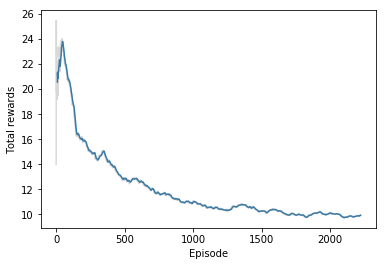

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

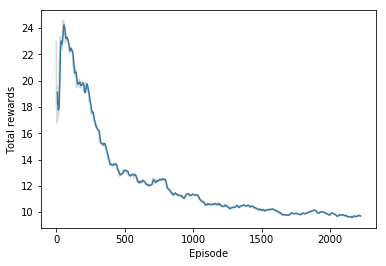

In [30]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

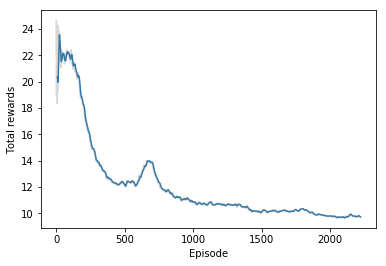

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

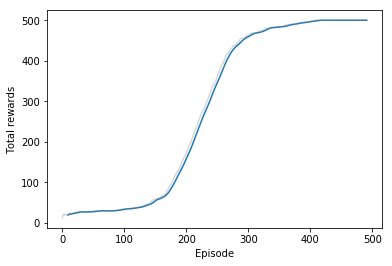

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

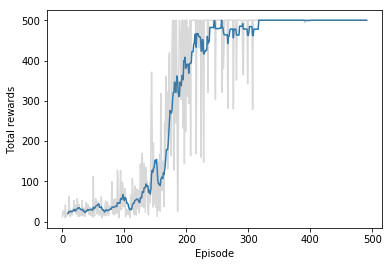

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.